## 线性回归
**理论知识参考：[链接1](https://www.bookstack.cn/read/Dive-into-DL-PyTorch/b823127c21ab292b.md), [链接2](https://tangshusen.me/Dive-into-DL-PyTorch/#/chapter03_DL-basics/3.1_linear-regression)**

 ### 1、线性回归的从零开始实现
 
 本节将介绍如何只利用Tensor和autograd来实现一个线性回归的训练。

首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示。

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

####  1.1 生成数据集
我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特$X \in R^{1000x2}$ , 我们使用线性回归模型真实权重$w=[2,-3.4]^T$ 和偏差$b=4.2$， 以及一个随机噪声$\in$来生成标签$y=XW + b + \in $,其中噪声项$\in $服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

注意，features的每一行是一个长度为2的向量，而labels的每一行是一个长度为1的向量（标量）。

In [4]:
print(features[0], labels[0])

tensor([-0.4254, -0.9107]) tensor(6.4425)


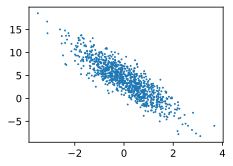

In [6]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

#### 1.2 读取数据
在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [7]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [8]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.2384, -1.3304],
        [-1.0942, -0.8112],
        [-2.3425, -1.2559],
        [ 0.7305, -1.1598],
        [ 0.6823, -0.0956],
        [ 0.2527,  1.7828],
        [-0.4301, -0.2692],
        [ 0.1905, -0.0503],
        [-0.3784, -1.2096],
        [-1.1473,  1.7660]]) tensor([ 8.2602,  4.7724,  3.7897,  9.6197,  5.8868, -1.3508,  4.2377,  4.7582,
         7.5542, -4.1060])


#### 1.3 初始化模型参数
我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [9]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [11]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

#### 1.4 定义模型
下面是线性回归的矢量计算表达式的实现。我们使用mm函数做矩阵乘法。

In [12]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

#### 1.5 定义损失函数
我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值y_hat的形状。以下函数返回的结果也将和y_hat的形状相同。

In [13]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

#### 1.6 定义优化算法
以下的sgd函数实现了小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [14]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

#### 1.7 训练模型
在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用.sum()将其求和得到一个标量，再运行l.backward()得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [15]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss
for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.050590
epoch 2, loss 0.000223
epoch 3, loss 0.000049
epoch 4, loss 0.000048
epoch 5, loss 0.000048
epoch 6, loss 0.000048
epoch 7, loss 0.000048
epoch 8, loss 0.000048
epoch 9, loss 0.000048
epoch 10, loss 0.000048


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [16]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9999],
        [-3.4000]], requires_grad=True)
4.2 
 tensor([4.2006], requires_grad=True)


### 2. 线性回归的简洁实现
随着深度学习框架的发展，开发深度学习应用变得越来越便利。实践中，我们通常可以用比上一节更简洁的代码来实现同样的模型。在本节中，我们将介绍如何使用PyTorch更方便地实现线性回归的训练。
### 2.1 生成数据集
我们生成与上一节中相同的数据集。其中features是训练数据特征，labels是标签。

In [17]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

#### 2.2 读取数据
PyTorch提供了data包来读取数据。由于data常用作变量名，我们将导入的data模块用Data代替。在每一次迭代中，我们将随机读取包含10个数据样本的小批量。

In [18]:
import torch.utils.data as Data
batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

这里data_iter的使用跟上一节中的一样。让我们读取并打印第一个小批量数据样本。

In [19]:
for X, y in data_iter:
    print(X, y)
    break

tensor([[-1.3074, -0.3501],
        [-0.2106, -0.8792],
        [ 1.8452, -0.2283],
        [ 1.2576,  0.2016],
        [ 1.0198, -0.9627],
        [ 0.2951,  2.3212],
        [-0.2340,  0.8472],
        [-0.8672,  1.0148],
        [ 0.7620,  1.2866],
        [ 0.5390, -1.0114]]) tensor([ 2.7650,  6.7826,  8.6764,  6.0399,  9.5102, -3.1209,  0.8498, -0.9713,
         1.3487,  8.7327])


#### 2.3 定义模型
在上一节从零开始的实现中，我们需要定义模型参数，并使用它们一步步描述模型是怎样计算的。当模型结构变得更复杂时，这些步骤将变得更繁琐。其实，PyTorch提供了大量预定义的层，这使我们只需关注使用哪些层来构造模型。下面将介绍如何使用PyTorch更简洁地定义线性回归。

首先，导入torch.nn模块。实际上，“nn”是neural networks（神经网络）的缩写。顾名思义，该模块定义了大量神经网络的层。之前我们已经用过了autograd，而nn就是利用autograd来定义模型。nn的核心数据结构是Module，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承nn.Module，撰写自己的网络/层。一个nn.Module实例应该包含一些层以及返回输出的前向传播（forward）方法。下面先来看看如何用nn.Module实现一个线性回归模型。

In [22]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y
net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


事实上我们还可以用nn.Sequential来更加方便地搭建网络，Sequential是一个有序的容器，网络层将按照在传入Sequential的顺序依次被添加到计算图中。

In [23]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )
# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......
# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


可以通过net.parameters()来查看模型所有的可学习参数，此函数将返回一个生成器。

In [24]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.4219,  0.3382]], requires_grad=True)
Parameter containing:
tensor([-0.1341], requires_grad=True)


回顾图3.1中线性回归在神经网络图中的表示。作为一个单层神经网络，线性回归输出层中的神经元和输入层中各个输入完全连接。因此，线性回归的输出层又叫全连接层。
> 注意：torch.nn仅支持输入一个batch的样本不支持单个样本输入，如果只有单个样本，可使用input.unsqueeze(0)来添加一维。

### 2.4 初始化模型参数
在使用net前，我们需要初始化模型参数，如线性回归模型中的权重和偏差。PyTorch在init模块中提供了多种参数初始化方法。这里的init是initializer的缩写形式。我们通过init.normal_将权重参数每个元素初始化为随机采样于均值为0、标准差为0.01的正态分布。偏差会初始化为零。

In [25]:
from torch.nn import init
init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

>注：如果这里的net是用3.3.3节一开始的代码自定义的，那么上面代码会报错，net[0].weight应改为net.linear.weight，bias亦然。因为net[0]这样根据下标访问子模块的写法只有当net是个ModuleList或者Sequential实例时才可以，详见4.1节。

#### 2.5 定义损失函数
PyTorch在nn模块中提供了各种损失函数，这些损失函数可看作是一种特殊的层，PyTorch也将这些损失函数实现为nn.Module的子类。我们现在使用它提供的均方误差损失作为模型的损失函数。 

In [26]:
loss = nn.MSELoss()

#### 2.6 定义优化算法
同样，我们也无须自己实现小批量随机梯度下降算法。torch.optim模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等。下面我们创建一个用于优化net所有参数的优化器实例，并指定学习率为0.03的小批量随机梯度下降（SGD）为优化算法。

In [27]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


我们还可以为不同子网络设置不同的学习率，这在finetune时经常用到。例：

In [33]:
optimizer =optim.SGD([
                # 如果对某个参数不指定学习率，就使用最外层的默认学习率
                {'params': net.linear.parameters()}, # lr=0.03
#                 {'params': net[0].parameters(), 'lr': 0.01}
            ], lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


有时候我们不想让学习率固定成一个常数，那如何调整学习率呢？主要有两种做法。一种是修改optimizer.param_groups中对应的学习率，另一种是更简单也是较为推荐的做法——新建优化器，由于optimizer十分轻量级，构建开销很小，故而可以构建新的optimizer。但是后者对于使用动量的优化器（如Adam），会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况。

In [34]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍

#### 2.7 训练模型
在使用Gluon训练模型时，我们通过调用optim实例的step函数来迭代模型参数。按照小批量随机梯度下降的定义，我们在step函数中指明批量大小，从而对批量中样本梯度求平均。

In [35]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 3.786494
epoch 2, loss: 4.314091
epoch 3, loss: 0.890134


下面我们分别比较学到的模型参数和真实的模型参数。我们从net获得需要的层，并访问其权重（weight）和偏差（bias）。学到的参数和真实的参数很接近。

In [36]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.7531, -2.8539]], requires_grad=True)
4.2 Parameter containing:
tensor([3.5381], requires_grad=True)
